# Info
Name:  

    ORACLES_SSFR_cloud_retrieval

Purpose:  

    Run the cloud retrieval on SSFR data from ORACLES 2016 and 2017, but only on the flagacaod times.
  
Input:

    none

Output:
   
    plots
    mat save files
  
Keywords:

    none
  
Dependencies:

    - numpy
    - matplotlib
    - scipy

  
Needed Files:

  - ...
    
History:

    Written: Samuel LeBlanc,Santa Cruz, CA, 2018-06-29

# Prepare the python environment

In [1]:
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import load_utils as lu
import Sp_parameters as Sp

In [4]:
import hdf5storage as hs
from path_utils import getpath
from write_utils import nearest_neighbor
from tqdm import tqdm_notebook as tqdm
import math

In [207]:
from scipy import interpolate

In [5]:
fp = getpath('ORACLES')
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

# Load files

In [9]:
days = ['20160830','20160831','20160902','20160904','20160906','20160908',
       '20160910','20160912','20160914','20160918','20160920','20160924','20160925','20160927']

## Load the SSFR ict files for 2016

In [26]:
ssfr_a, ssfr_ah = [],[]
for d in days:
    sf,sfh = lu.load_ict(fp+'data_other/ssfr/SSFR_P3_{}_R1.ict'.format(d),return_header=True)
    ssfr_a.append(lu.recarray_to_dict(sf))
    ssfr_ah.append(sfh)

('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1250', 'UP1650', 'UP2100', 'LON', 'LAT', 'ALT', 'PITCH', 'ROLL', 'HEAD')
('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1250', 'UP1650', 'UP2100', 'LON', 'LAT', 'ALT', 'PITCH', 'ROLL', 'HEAD')
('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1250', 'UP1650', 'UP2100', 'LON', 'LAT', 'ALT', 'PITCH', 'ROLL', 'HEAD')
('Start_UTC', 'DN415', 'DN440', 'DN500', 'DN675', 'DN870', 'DN990', 'DN1020', 'DN1064', 'DN1250', 'DN1650', 'DN2100', 'UP415', 'UP440', 'UP500', 'UP675', 'UP870', 'UP990', 'UP1020', 'UP1064', 'UP1

In [12]:
ssfr_ah[0]

['65, 1001\n',
 'Schmidt, Sebastian\n',
 'University of Colorado at Boulder \n',
 'SW Spectral Irradiance from P3 Solar Spectral Flux Radiometer \n',
 'ORACLES 2016\n',
 '1, 1 \n',
 '2016,08,30,     2017,06,29\n',
 '      1.00000 \n',
 'Start_UTC, seconds\n',
 '          28 \n',
 '1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1\n',
 '-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000,-9999.0000000\n',
 'DN415, W m^-2 nm^-1, Downward Shortwave Irradiance at 415.896 nm \n',
 'DN440, W m^-2 nm^-1, Downward Shortwave Irradiance at 439.204 nm \n',
 'DN500, W m^-2 nm^-1, Downward Shortwave Irradiance at 499.224 nm \n',
 'DN675, W m^-2 nm^-1, Downward Shortwave Ir

In [13]:
ssfr_a[0]

array([ ( 7.15027778,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,  nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,  nan,  14.6427155, -22.9804802,  121.2090849,   5.8463597,   5.8463597, -107.1999969),
       ( 7.15055556,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,  nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,  nan,  14.6422005, -22.9806519,  119.8221336, -22.786274 , -22.786274 , -107.       ),
       ( 7.15083333,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,  nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,  nan,  14.6416855, -22.9

## Load the 4STAR files with flagacaod

In [25]:
star_a, star_ah = [],[]
for d in days:
    sf,sfh = lu.load_ict(fp+'aod_ict/v8/4STAR-AOD_P3_{}_R3.ict'.format(d),return_header=True)
    star_a.append(lu.recarray_to_dict(sf))
    star_ah.append(sfh)

('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD0530', 'AOD0532', 'AOD0550', 'AOD0606', 'AOD0620', 'AOD0660', 'AOD0675', 'AOD0700', 'AOD0781', 'AOD0865', 'AOD1020', 'AOD1040', 'AOD1064', 'AOD1236', 'AOD1250', 'AOD1559', 'AOD1627', 'AOD1650', 'UNCAOD0355', 'UNCAOD0380', 'UNCAOD0452', 'UNCAOD0470', 'UNCAOD0501', 'UNCAOD0520', 'UNCAOD0530', 'UNCAOD0532', 'UNCAOD0550', 'UNCAOD0606', 'UNCAOD0620', 'UNCAOD0660', 'UNCAOD0675', 'UNCAOD0700', 'UNCAOD0781', 'UNCAOD0865', 'UNCAOD1020', 'UNCAOD1040', 'UNCAOD1064', 'UNCAOD1236', 'UNCAOD1250', 'UNCAOD1559', 'UNCAOD1627', 'UNCAOD1650', 'flag_acaod')
('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD05

('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'flag_acaod', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD0530', 'AOD0532', 'AOD0550', 'AOD0606', 'AOD0620', 'AOD0660', 'AOD0675', 'AOD0700', 'AOD0781', 'AOD0865', 'AOD1020', 'AOD1040', 'AOD1064', 'AOD1236', 'AOD1250', 'AOD1559', 'AOD1627', 'AOD1650', 'UNCAOD0355', 'UNCAOD0380', 'UNCAOD0452', 'UNCAOD0470', 'UNCAOD0501', 'UNCAOD0520', 'UNCAOD0530', 'UNCAOD0532', 'UNCAOD0550', 'UNCAOD0606', 'UNCAOD0620', 'UNCAOD0660', 'UNCAOD0675', 'UNCAOD0700', 'UNCAOD0781', 'UNCAOD0865', 'UNCAOD1020', 'UNCAOD1040', 'UNCAOD1064', 'UNCAOD1236', 'UNCAOD1250', 'UNCAOD1559', 'UNCAOD1627', 'UNCAOD1650')
('Start_UTC', 'Latitude', 'Longitude', 'GPS_Alt', 'qual_flag', 'amass_aer', 'AOD_angstrom_470_865', 'AOD_polycoef_a2', 'AOD_polycoef_a1', 'AOD_polycoef_a0', 'AOD0355', 'AOD0380', 'AOD0452', 'AOD0470', 'AOD0501', 'AOD0520', 'AOD05

In [18]:
ssfr_a[3]['Start_UTC'][100]

7.5780555555555553

## Get the flagacaod on the timescale of the ssfr measurements

In [243]:
for i,d in enumerate(days):
    fa = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['flag_acaod'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['flagacaod'] = fa
    am = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['amass_aer'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['airmass'] = am
    ssfr_a[i]['sza'] = np.arccos(1.0/am)*180.0/np.pi
    aod = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD0501'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['AOD_500'] = aod
    a2 = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD_polycoef_a2'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['a2'] = a2
    a1 = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD_polycoef_a1'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['a1'] = a1
    a0 = nearest_neighbor(star_a[i]['Start_UTC'],star_a[i]['AOD_polycoef_a0'],ssfr_a[i]['Start_UTC'],dist=3.0/3600.0)
    ssfr_a[i]['a0'] = a0

In [220]:
ssfr_a[0]['flagacaod'].shape,ssfr_a[0]['Start_UTC'].shape

((4929,), (4929,))

## Load the LUT for 2wvl reflectance retrieval

In [30]:
lut = hs.loadmat(fp+'rtm/v5_irr_ORACLES_lut.mat')

In [31]:
lut.keys()

[u'tau',
 u'rad',
 u'lut_details',
 u'sza',
 u'irr_dn_diff',
 u'irr_dn',
 u'zout',
 u'wvl',
 u'phase',
 u'ref',
 u'irr_up']

## Combine into one array

In [249]:
nm = ssfr_a[1].keys()

In [250]:
ar = {}
for n in ssfr_a[1].keys():
    ar[n] = np.array([])

In [251]:
ar['days'] = np.array([])

In [252]:
for i,d in enumerate(days):
    ar['days'] = np.append(ar['days'],np.zeros_like(ssfr_a[i]['Start_UTC'])+i)
    for n in nm:
        try:
            ar[n] = np.append(ar[n],ssfr_a[i][n])
        except:
            print 'problem with :'+n
            ar[n] = np.append(ar[n],ssfr_a[i]['Start_UTC']*0)

# Format the LUT and data for retrievals

In [253]:
class so:
    pass

## Set up the data

In [254]:
ar['meas'] = so
ar['meas'].sza = ar['sza']
ar['meas'].Rvis = ar['UP500']/ar['DN500']
ar['meas'].Rnir = ar['UP1650']/ar['DN1650']
ar['meas'].utc = ar['Start_UTC']

In [255]:
# filter out the bad data. 
bad = (ar['meas'].Rvis > 1.0) & (ar['flagacaod']==0) & (ar['meas'].Rnir > 1.0)
ar['meas'].Rvis[bad] = np.nan
ar['meas'].Rvis[bad] = np.nan

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [256]:
igood = np.where((np.isfinite(ar['meas'].Rvis)) & (ar['meas'].Rvis > 0.0) & (np.isfinite(ar['meas'].Rnir)) & \
(ar['meas'].Rnir > 0.0) & (ar['flagacaod']==1))[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


## set up the LUT

In [257]:
lut.keys()

[u'tau',
 u'rad',
 'ref_hi',
 'tau_hi',
 u'lut_details',
 'Rnir_hi',
 u'sza',
 'Rvis',
 u'irr_dn_diff',
 u'irr_dn',
 u'zout',
 'Rnir',
 u'wvl',
 u'phase',
 'Rvis_hi',
 u'ref',
 u'irr_up']

In [124]:
lut['tau'].shape, lut['ref'].shape, lut['sza'].shape, lut['irr_dn'].shape, lut['wvl'].shape, lut['zout'], lut['phase']

((27,), (23,), (48,), (1, 2, 3, 23, 27, 48), (2,), [0.2, 1.5, 100.0], ['wc'])

In [121]:
lut['Rvis'] = np.zeros([23,27,48])
lut['Rnir'] = np.zeros([23,27,48])

In [122]:
for ir,r in enumerate(lut['ref']):
    for it,t in enumerate(lut['tau']):
        for iz,s in enumerate(lut['sza']):
            lut['Rvis'][ir,it,iz] = lut['irr_up'][0,0,1,ir,it,iz]/lut['irr_dn'][0,0,1,ir,it,iz]
            lut['Rnir'][ir,it,iz] = lut['irr_up'][0,1,1,ir,it,iz]/lut['irr_dn'][0,1,1,ir,it,iz]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [126]:
lut['sza']

array([ 11.36487697,  20.83969366,  26.76550058,  31.2732978 ,
        34.94801372,  38.05665663,  40.74905438,  43.11972483,
        45.23300465,  47.13508975,  48.86048959,  50.43578157,
        51.88193569,  53.21582641,  54.451256  ,  55.5996703 ,
        56.67067347,  57.67240684,  58.61183354,  59.49495605,
        60.3269852 ,  61.11247301,  61.85541869,  62.55935386,
        63.22741194,  63.86238505,  64.46677106,  65.04281282,
        65.59253108,  66.11775223,  66.62013188,  67.10117502,
        67.56225324,  68.00461964,  68.4294217 ,  68.83771245,
        69.23046027,  69.60855741,  69.97282752,  70.32403224,
        70.6628771 ,  70.99001664,  71.30605908,  71.61157038,
        71.90707798,  72.193074  ,  72.47001827,  72.73834093])

### Make a hires version of the LUT

In [206]:
lut['tau_hi'] = np.hstack([np.arange(0,25,0.5),np.arange(25,50,1),np.arange(50,102.5,2.5)])
lut['ref_hi'] = np.hstack([np.arange(0,15,0.25),np.arange(15,30.5,0.5)])

In [208]:
len(lut['tau_hi']), len(lut['ref_hi'])

(96, 91)

In [209]:
lut['Rvis_hi'] = np.zeros([91,96,48])
lut['Rnir_hi'] = np.zeros([91,96,48])

In [210]:
for i,z in enumerate(lut['sza']):
    fv = interpolate.RectBivariateSpline(lut['ref'],lut['tau'],lut['Rvis'][:,:,i],kx=1,ky=1)
    lut['Rvis_hi'][:,:,i] = fv(lut['ref_hi'],lut['tau_hi'])
    fn = interpolate.RectBivariateSpline(lut['ref'],lut['tau'],lut['Rnir'][:,:,i],kx=1,ky=1)
    lut['Rnir_hi'][:,:,i] = fn(lut['ref_hi'],lut['tau_hi'])

# Run the retrieval

In [258]:
ar['tau'], ar['ref'] = np.zeros_like(ar['sza'])*np.nan,np.zeros_like(ar['sza'])*np.nan

In [259]:
ar['ki'] = np.zeros_like(ar['sza'])

In [260]:
pbar = tqdm(total=len(ar['sza']))
for i,s in enumerate(ar['sza']):
    pbar.update()
    if (s>73.0) | (np.isnan(s)):
        continue
    if not i in igood:
        continue
    isza = np.argmin(np.abs(lut['sza']-s))
    ki = (ar['meas'].Rvis[i]-lut['Rvis_hi'][:,:,isza]/ar['meas'].Rvis[i])**2+(ar['meas'].Rnir[i]-lut['Rnir_hi'][:,:,isza]/ar['meas'].Rnir[i])**2
    kimin = np.unravel_index(np.nanargmin(ki),ki.shape)
    ar['ki'][i] = np.nanmin(ki)
    ar['tau'][i],ar['ref'][i] = lut['tau_hi'][kimin[1]],lut['ref_hi'][kimin[0]]

HBox(children=(IntProgress(value=0, max=380923), HTML(value=u'')))

# Plot the retrieval results

<IPython.core.display.Javascript object>


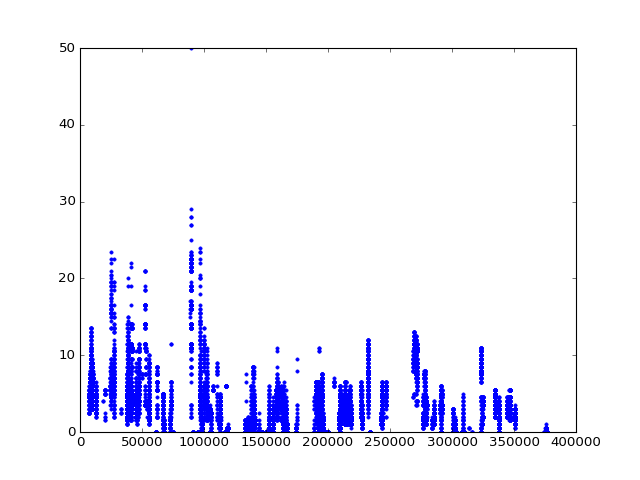

In [215]:
plt.figure()
plt.plot(ar['tau'],'.')

<IPython.core.display.Javascript object>


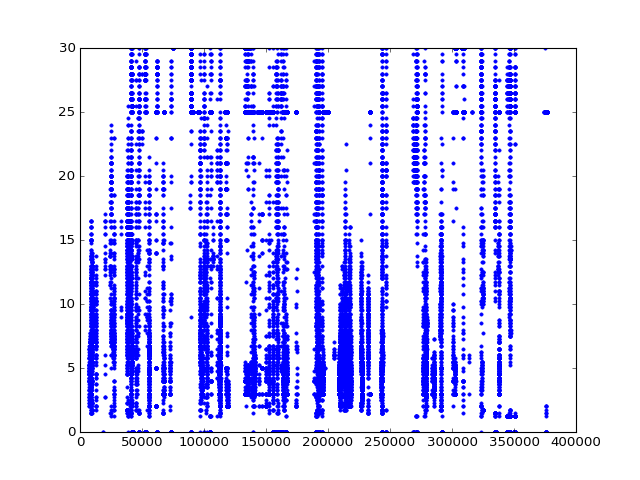

In [216]:
plt.figure()
plt.plot(ar['ref'],'.')

In [261]:
len(np.where(np.isfinite(ar['ref']))[0])

30270

In [262]:
len(ar['ref'])

380923

# Save the retrieved output

In [263]:
out = {}

In [264]:
ar.keys()

['tau',
 'UP1250',
 'DN415',
 'UP500',
 'sza',
 'LON',
 'UP870',
 'AOD_500',
 'ki',
 'DN1650',
 'DN2100',
 'flagcaod',
 'UP990',
 'flagacaod',
 'UP1064',
 'DN675',
 'ref',
 'UP415',
 'HEAD',
 'airmass',
 'UP1020',
 'UP2100',
 'UP675',
 'DN500',
 'a1',
 'DN1020',
 'DN870',
 'DN440',
 'flacaod',
 'meas',
 'DN1250',
 'a0',
 'UP440',
 'DN1064',
 'Start_UTC',
 'days',
 'UP1650',
 'a2',
 'PITCH',
 'LAT',
 'DN990',
 'ALT',
 'ROLL']

In [265]:
out['tau'] = ar['tau']
out['ref'] = ar['ref']
out['sza'] = ar['sza']
out['aod'] = ar['AOD_500']
out['days'] = ar['days']
out['utc'] = ar['Start_UTC']
out['lat'] = ar['LAT']
out['lon'] = ar['LON']
out['a0'],out['a1'],out['a2'] = ar['a0'],ar['a1'],ar['a2']

In [266]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

In [267]:
hs.savemat(fp+'data_other/ssfr_2016_retrieved_COD.mat',out)

In [268]:
out['days']

array([  0.,   0.,   0., ...,  13.,  13.,  13.])